# Analyzing single-lineage models

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.io import DataFile, data_path, project_root
from speclet.managers.posterior_data_manager import (
    PosteriorDataManager,
    PosteriorDataManagers,
)
from speclet.model_configuration import read_model_configurations
from speclet.plot import set_speclet_theme
from speclet.plot.color_pal import pal_to_legend_handles
from speclet.project_configuration import arviz_config, get_model_configuration_file
from speclet.project_enums import ModelFitMethod

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 709
np.random.seed(RANDOM_SEED)
arviz_config()

# File paths
config_path = project_root() / get_model_configuration_file()

### Data

#### Model posteriors

In [5]:
model_configs = read_model_configurations(config_path, active_only=True)
f"Number of configurations: {len(model_configs.configurations)}"

'Number of configurations: 13'

In [6]:
model_names = [c.name for c in model_configs.configurations]
model_names.sort()
pattern = r"(?<=hnb-single-lineage-).*$"
lineage_names = [re.findall(pattern, m)[0] for m in model_names]
lineage_names = [n.replace("_", " ") for n in lineage_names]

# Skip some lineages because they are incomplete at the moment.
SKIP_LINEAGES = [
    "blood",
    "colorectal",
    "bone",
    "central nervous system",
    "kidney",
    "lung",
]
for skip_line in SKIP_LINEAGES:
    i = lineage_names.index(skip_line)
    _ = model_names.pop(i), lineage_names.pop(i)


postmen = PosteriorDataManagers(
    names=model_names,
    fit_methods=ModelFitMethod.PYMC_NUMPYRO,
    config_paths=config_path,
    keys=lineage_names,
)

In [7]:
postmen.keys

['bile duct', 'breast', 'cervix', 'esophagus', 'eye', 'gastric', 'liver']

In [8]:
lineage_pal = {
    line: sns.color_palette("Dark2")[i] for i, line in enumerate(lineage_names)
}
lineage_pal

{'bile duct': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 'breast': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 'cervix': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 'esophagus': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 'eye': (0.4, 0.6509803921568628, 0.11764705882352941),
 'gastric': (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 'liver': (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)}

## Analysis

In [9]:
def summarize_variable_per_lineage(
    pms: PosteriorDataManagers,
    var_name: str,
    extract_names: str | list[str] | None = None,
) -> pd.DataFrame:
    posteriors = pd.DataFrame()

    for lineage, lineage_pm in postmen.as_dict().items():
        post = (
            lineage_pm.posterior_summary.query(f"var_name == '{var_name}'")
            .reset_index(drop=True)
            .assign(lineage=lineage)
        )
        if len(post) == 0:
            continue

        if extract_names is not None:
            post = extract_coords_param_names(
                post, names=extract_names, col="parameter"
            )

        posteriors = pd.concat([posteriors, post])

    return posteriors.reset_index(drop=True)

In [10]:
mu_a_posteriors = summarize_variable_per_lineage(
    postmen, var_name="mu_a", extract_names="hugo_symbol"
)
mu_a_posteriors.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name,lineage,hugo_symbol
0,mu_a[A1BG],0.322,0.124,0.108,0.503,0.002,0.002,3526.0,3064.0,1.0,mu_a,bile duct,A1BG
1,mu_a[A1CF],0.258,0.117,0.075,0.444,0.002,0.001,3971.0,3275.0,1.0,mu_a,bile duct,A1CF
2,mu_a[A2M],0.196,0.121,-0.003,0.387,0.002,0.001,3760.0,3080.0,1.0,mu_a,bile duct,A2M
3,mu_a[A2ML1],0.318,0.124,0.112,0.503,0.002,0.001,3796.0,2968.0,1.0,mu_a,bile duct,A2ML1
4,mu_a[A3GALT2],0.111,0.123,-0.072,0.320,0.002,0.002,3177.0,3273.0,1.0,mu_a,bile duct,A3GALT2


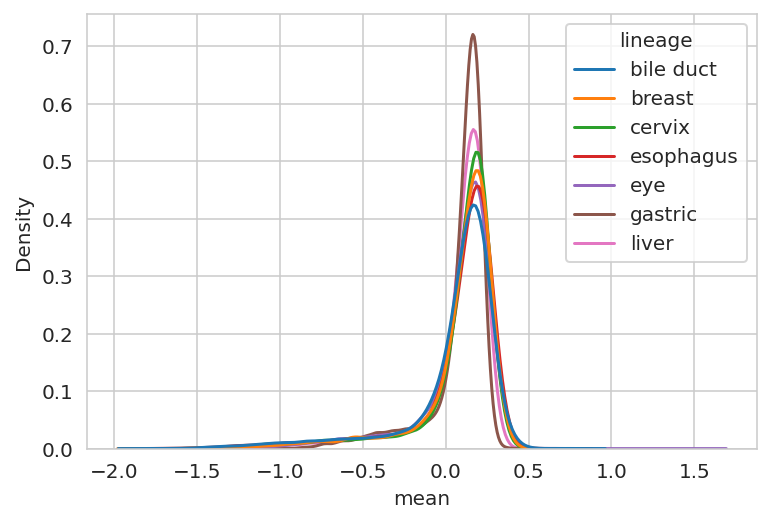

In [11]:
sns.kdeplot(data=mu_a_posteriors, x="mean", hue="lineage")
plt.show()

(0.0, 100.0)

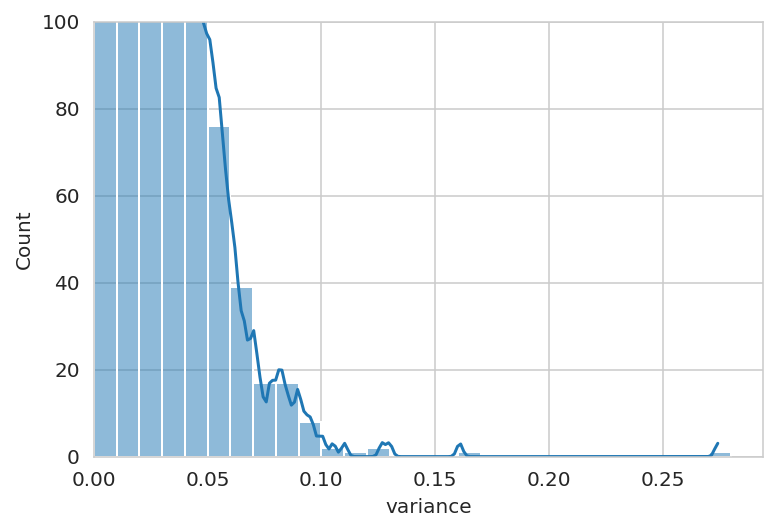

In [12]:
mu_a_posterior_variability = (
    mu_a_posteriors.groupby("hugo_symbol")["mean"]
    .var()
    .reset_index()
    .rename(columns={"mean": "variance"})
)
ax = sns.histplot(
    data=mu_a_posterior_variability, x="variance", binwidth=0.01, kde=True
)
ax.set_xlim(0, None)
ax.set_ylim(0, 100)

In [13]:
mu_a_posterior_variability.sort_values(["variance"], ascending=False).query(
    "variance > 0.1"
)

,hugo_symbol,variance
16203,TP53,0.274102
12642,RAN,0.160746
16644,TXNL4A,0.129903
3953,DDX3X,0.126612
13236,RPL4,0.110131
1664,BUB3,0.105167
11831,POLR2L,0.100974


In [14]:
k_posteriors = summarize_variable_per_lineage(
    postmen, var_name="k", extract_names="cell_chrom"
).assign(
    depmap_id=lambda d: [x.split("__")[0] for x in d["cell_chrom"]],
    sgrna_target_chr=lambda d: [x.split("__")[1] for x in d["cell_chrom"]],
)
k_posteriors.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name,lineage,cell_chrom,depmap_id,sgrna_target_chr
0,k[ACH-000141__1],0.053,0.018,0.026,0.082,0.001,0.001,577.0,903.0,1.0,k,bile duct,ACH-000141__1,ACH-000141,1
1,k[ACH-000141__2],0.054,0.019,0.025,0.085,0.001,0.000,715.0,1493.0,1.0,k,bile duct,ACH-000141__2,ACH-000141,2
2,k[ACH-000141__3],0.043,0.030,-0.005,0.090,0.001,0.001,1650.0,2048.0,1.0,k,bile duct,ACH-000141__3,ACH-000141,3
3,k[ACH-000141__4],0.070,0.021,0.039,0.105,0.001,0.001,805.0,1579.0,1.0,k,bile duct,ACH-000141__4,ACH-000141,4
4,k[ACH-000141__5],0.082,0.020,0.049,0.112,0.001,0.001,737.0,1573.0,1.0,k,bile duct,ACH-000141__5,ACH-000141,5


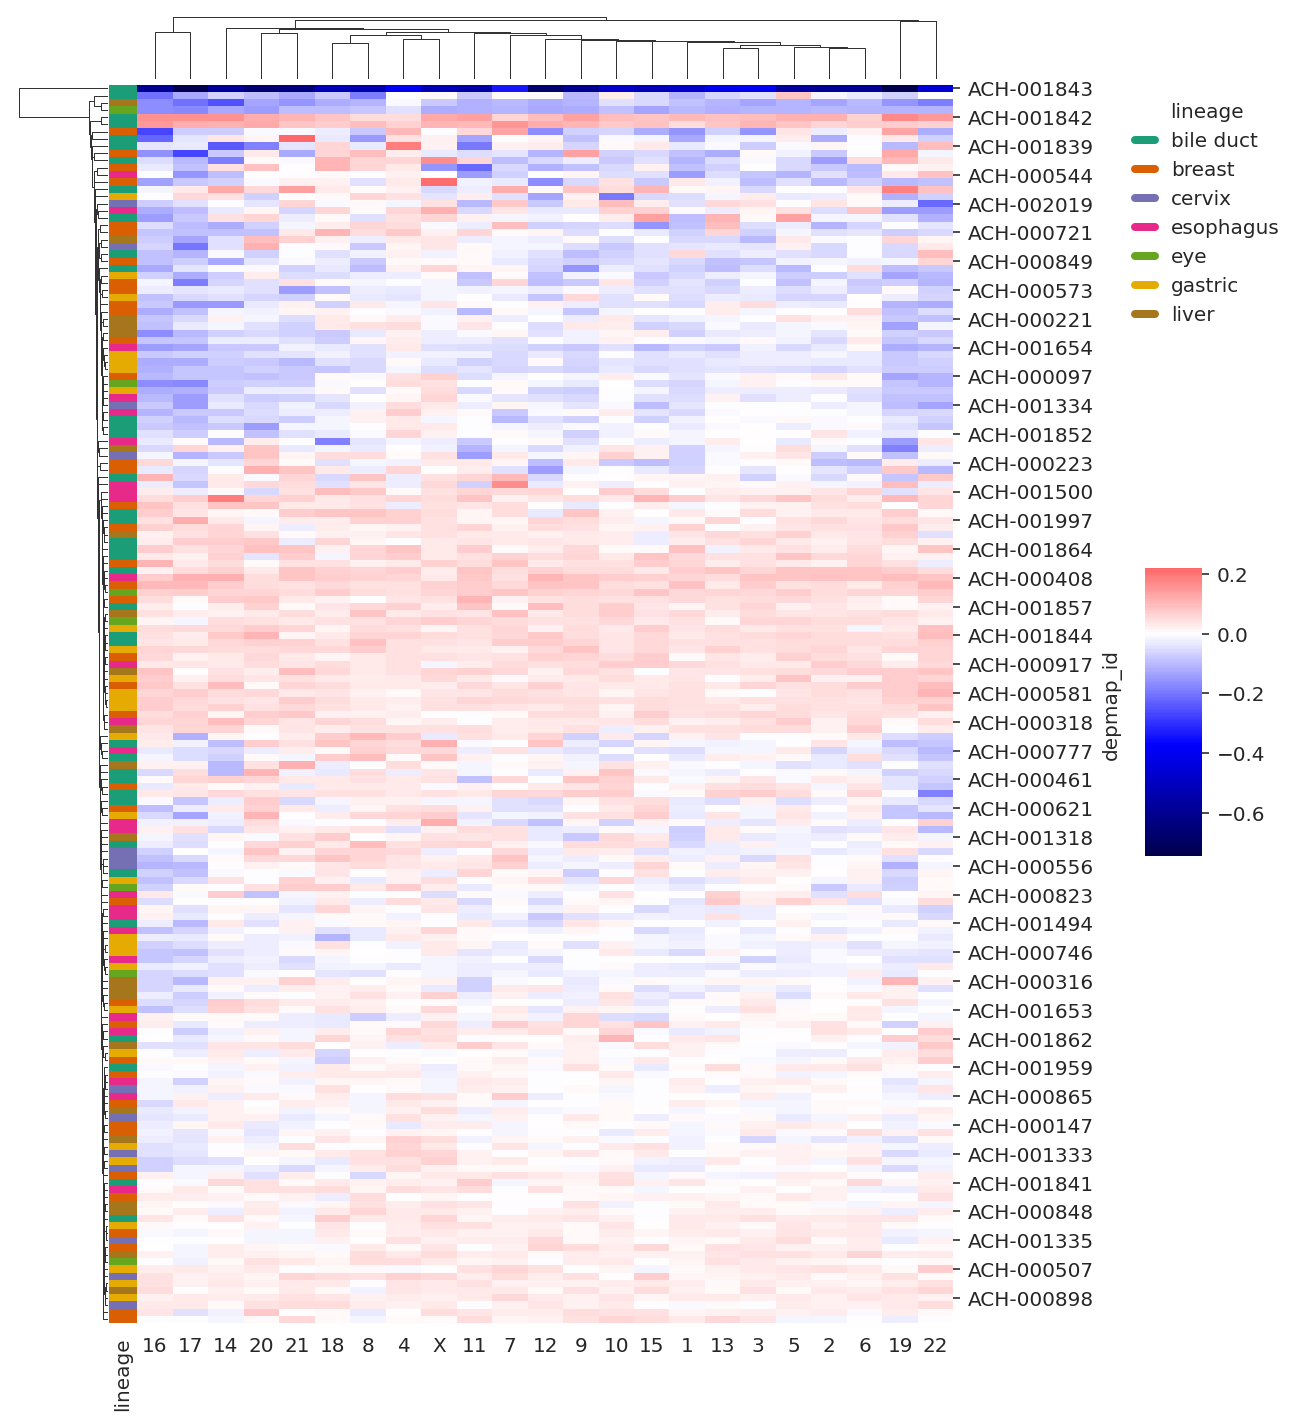

In [15]:
row_colors = (
    k_posteriors[["lineage", "depmap_id"]]
    .drop_duplicates()
    .set_index("depmap_id")["lineage"]
    .map(lineage_pal)
)

k_posteriors_wide = k_posteriors.pivot_wider(
    index="depmap_id", names_from="sgrna_target_chr", values_from="mean"
).set_index("depmap_id")
fg = sns.clustermap(
    k_posteriors_wide,
    cmap="seismic",
    center=0,
    row_colors=row_colors,
    figsize=(8, 10),
    cbar_pos=(1, 0.4, 0.05, 0.2),
    dendrogram_ratio=(0.1, 0.05),
)
fg.ax_heatmap.legend(
    handles=pal_to_legend_handles(lineage_pal, lw=4),
    title="lineage",
    loc="upper left",
    bbox_to_anchor=(1.2, 1),
    handlelength=1,
    frameon=False,
)
plt.show()

In [16]:
f_posteriors = summarize_variable_per_lineage(
    postmen, var_name="f", extract_names="hugo_symbol"
)
f_posteriors.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name,lineage,hugo_symbol
0,f[A1BG],-0.004,0.114,-0.173,0.186,0.001,0.002,9842.0,2579.0,1.0,f,bile duct,A1BG
1,f[A1CF],-0.006,0.094,-0.152,0.148,0.001,0.002,9425.0,2860.0,1.0,f,bile duct,A1CF
2,f[A2M],-0.010,0.088,-0.142,0.137,0.001,0.002,8899.0,2536.0,1.0,f,bile duct,A2M
3,f[A2ML1],0.016,0.088,-0.121,0.159,0.001,0.002,12009.0,2502.0,1.0,f,bile duct,A2ML1
4,f[A3GALT2],0.073,0.099,-0.082,0.231,0.001,0.001,9726.0,2818.0,1.0,f,bile duct,A3GALT2


In [17]:
hdi_outside_zero = (f_posteriors["hdi_5.5%"] * f_posteriors["hdi_94.5%"]).values > 0
effect_size_filter = f_posteriors["mean"].abs().values > 0.1
f_posteriors["hit"] = hdi_outside_zero * effect_size_filter

Maybe add an additional filter for effect size and frequency of mutation in the cell lines.

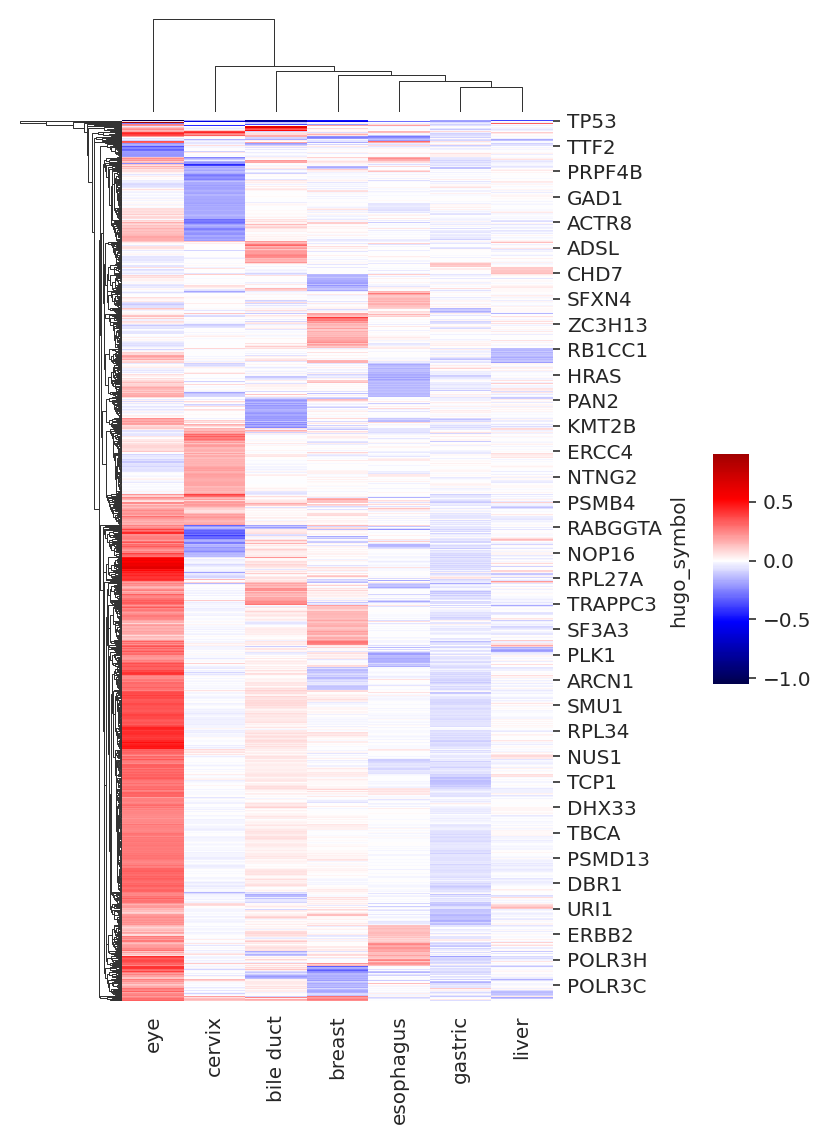

In [18]:
f_hit_genes = f_posteriors.query("hit")["hugo_symbol"].unique()
plot_df = (
    f_posteriors.filter_column_isin("hugo_symbol", f_hit_genes)
    .pivot_wider(index="hugo_symbol", names_from="lineage", values_from="mean")
    .set_index("hugo_symbol")
)
sns.clustermap(
    plot_df,
    cmap="seismic",
    center=0,
    figsize=(5, 8),
    dendrogram_ratio=(0.2, 0.1),
    cbar_pos=(1, 0.4, 0.05, 0.2),
)

Possible analyses:

- heatmap of posteriors of `k` and `m` by TP53 mutation status
- most variable genes in `f` to highlight tissue-specificity of dependency
- correlation network of lineages by `f`
- description of certain genes (eg. KRAS, PIK3CA, TP53) across all lineages
- for cancer genes that were in multiple lineages, compare the hits in the comutation variable

In [19]:
def filter_posterior_summmary_parameter(
    postmen: PosteriorDataManagers,
    pattern: str,
    var_names: str | list[str] | None = None,
) -> pd.DataFrame:
    res: list[pd.DataFrame] = []
    for lineage, lineage_pm in postmen.as_dict().items():
        res.append(
            lineage_pm.posterior_summary.filter_string("parameter", pattern).assign(
                lineage=lineage
            )
        )

    res_df = pd.concat(res)
    if var_names is not None:
        if isinstance(var_names, str):
            var_names = [var_names]
        res_df = res_df.filter_column_isin("var_name", var_names)

    return res_df.reset_index(drop=True)

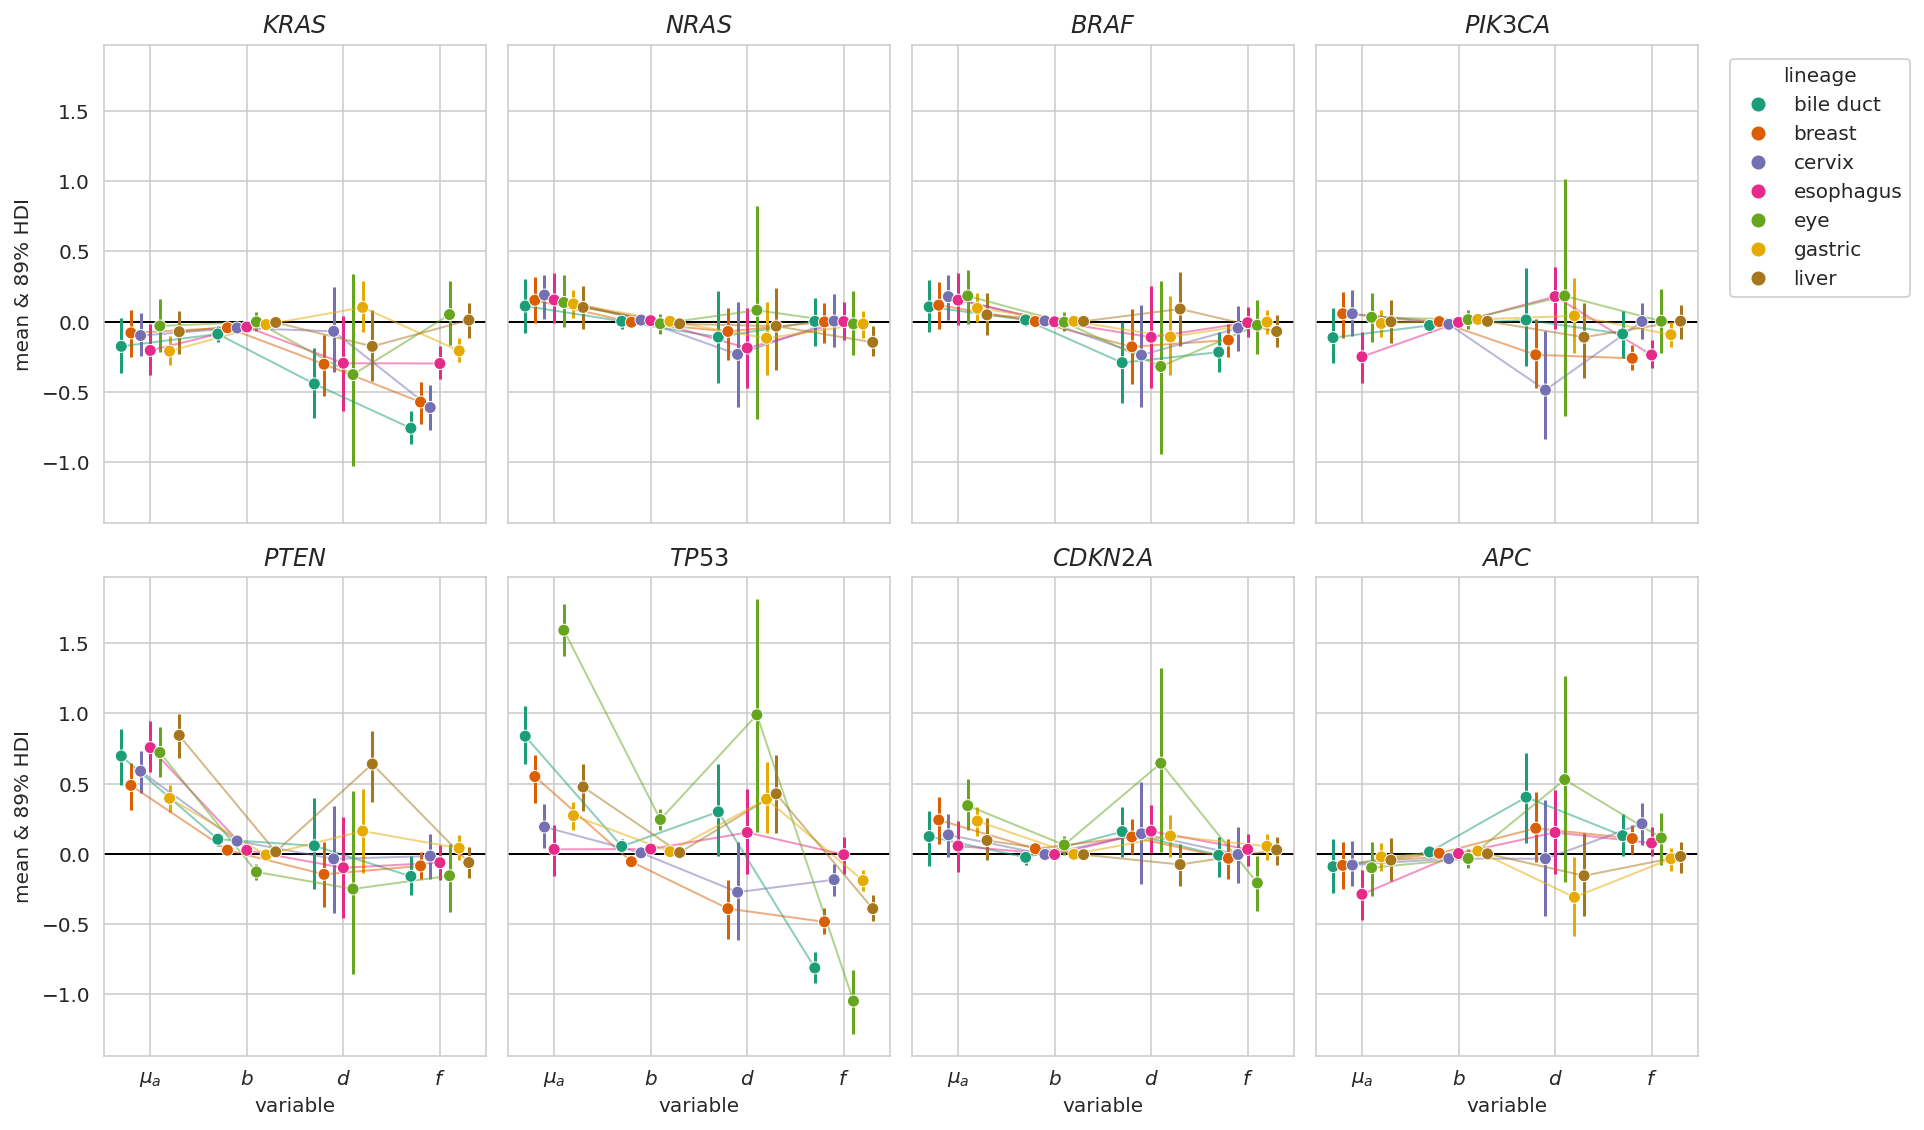

In [20]:
genes = ["KRAS", "NRAS", "BRAF", "PIK3CA", "PTEN", "TP53", "CDKN2A", "APC"]
var_names = {"mu_a": r"$\mu_a$", "b": "$b$", "d": "$d$", "f": "$f$"}

fig, axes = plt.subplots(
    nrows=2, ncols=len(genes) // 2, figsize=(12, 8), sharex=True, sharey=True
)

dx = np.linspace(-0.3, 0.3, len(postmen))
dodge = {line: dx[i] for i, line in enumerate(postmen.keys)}

for ax, gene in zip(axes.flatten(), genes):
    ax.set_title(f"${gene}$")
    data = filter_posterior_summmary_parameter(
        postmen, f"{gene}]", var_names=list(var_names.keys())
    )
    data["var_name"] = pd.Categorical(
        data["var_name"], categories=list(var_names.keys())
    )
    _x = data["var_name"].cat.codes
    _x += np.array([dodge[line] for line in data["lineage"]])
    data["x"] = _x

    colors = data["lineage"].map(lineage_pal).values
    ax.vlines(x=data["x"], ymin=data["hdi_5.5%"], ymax=data["hdi_94.5%"], colors=colors)
    sns.scatterplot(
        data=data,
        x="x",
        y="mean",
        hue="lineage",
        palette=lineage_pal,
        ax=ax,
        zorder=10,
    )
    sns.lineplot(
        data=data,
        x="x",
        y="mean",
        hue="lineage",
        palette=lineage_pal,
        ax=ax,
        zorder=5,
        alpha=0.5,
        linewidth=1,
    )
    ax.get_legend().remove()
    ax.axhline(0, color="k", lw=1, zorder=1)
    ax.set_xticks(
        ticks=np.arange(data["var_name"].nunique()),
        labels=[var_names[v] for v in data["var_name"].cat.categories],
    )

fig.legend(
    handles=pal_to_legend_handles(lineage_pal, lw=0, marker="o"),
    title="lineage",
    loc="upper left",
    bbox_to_anchor=(1, 0.95),
)

for ax in axes[:, 0]:
    ax.set_ylabel("mean & 89% HDI")
for ax in axes[-1, :]:
    ax.set_xlabel("variable")

fig.tight_layout()
plt.show()

In [21]:
def get_cancer_genes(pm: PosteriorDataManager) -> list[str]:
    if (cgs := pm.trace.posterior.coords.get("cancer_gene")) is None:
        return []
    return cgs.values.tolist()


def get_all_cancer_genes(postmen: PosteriorDataManagers) -> dict[str, list[str]]:
    cgs: dict[str, list[str]] = {}
    for lineage, pm in postmen.as_dict().items():
        cgs[lineage] = get_cancer_genes(pm)
    return cgs

In [22]:
cancer_genes = get_all_cancer_genes(postmen)
cancer_genes

{'bile duct': [],
 'breast': ['BRCA2', 'PIK3CA'],
 'cervix': [],
 'esophagus': ['LRP1B'],
 'eye': [],
 'gastric': ['ATR', 'CDH1', 'PIK3CA', 'PTPN13', 'PTPRT', 'ZFHX3'],
 'liver': ['AXIN1']}

In [23]:
h_post_summary = summarize_variable_per_lineage(
    postmen, var_name="h", extract_names=["hugo_symbol", "cancer_gene"]
)

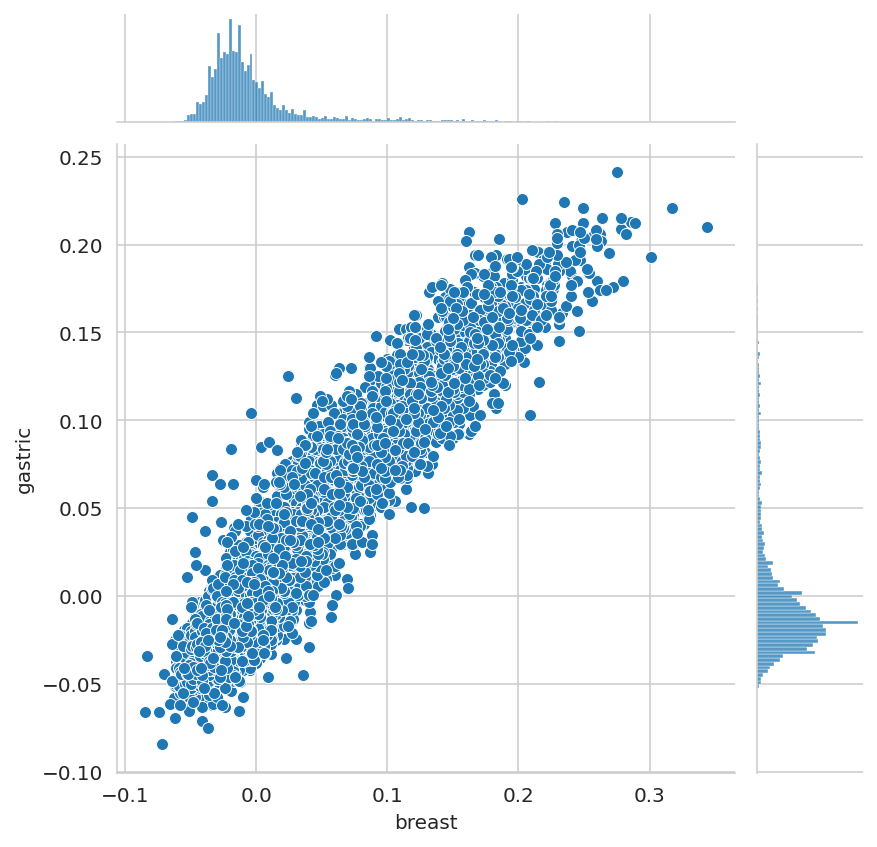

In [24]:
pik3ca_h_post_summary = (
    h_post_summary.filter_column_isin("cancer_gene", ["PIK3CA"])
    .reset_index(drop=True)
    .pivot_wider(index="hugo_symbol", names_from="lineage", values_from="mean")
)

sns.jointplot(data=pik3ca_h_post_summary, x="breast", y="gastric");

---

In [25]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.42 minutes


In [26]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-08-17

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.71.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-81.o2.rc.hms.harvard.edu

Git branch: expand-lineages

re        : 2.2.1
arviz     : 0.12.1
seaborn   : 0.11.2
plotnine  : 0.0.0
pandas    : 1.4.3
numpy     : 1.23.1
matplotlib: 3.5.2

